In [ ]:
!pip install langchain langsmith langgraph arxiv
!pip install langchain_community
!pip install langchain-groq

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

In [ ]:
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun
from langchain_groq import ChatGroq

In [ ]:
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END

In [ ]:

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)



tools = [arxiv_tool]

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

from google.colab import userdata
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=GROQ_API_KEY, model_name="llama3-8b-8192")
llm_tools = llm.bind_tools(tools=tools)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x799993286950>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7999933db310>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
def research_agent(state: State):
    return {
        "messages": [
            llm_tools.invoke(state["messages"])
        ]
    }

In [ ]:
graph_builder = StateGraph(State)
graph_builder.add_node("research_agent", research_agent)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("research_agent", tools_condition)
graph_builder.add_edge("tools", "research_agent")
graph_builder.add_edge(START, "research_agent")
graph = graph_builder.compile()



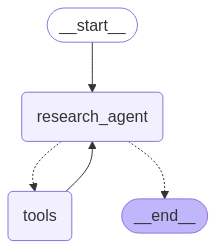

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Graph rendering failed")




In [ ]:
user_input = "Summarize research on brain-computer interfaces"

events = graph.stream({"messages": [("user", user_input)]}, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()



================================ Human Message =================================

Summarize recent research on brain-computer interfaces
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_pgjw)
 Call ID: call_pgjw
  Args:
    query: Recent research on brain-computer interfaces
================================= Tool Message =================================
Name: arxiv

Published: 2013-02-11
Title: Metrics for Assessing The Design of Software Interfaces
Authors: Hani Abdeen, Osama Shata
Summary: Recent studies have largely investigated the detection of class design
anomalies. They proposed a large set of metrics that help in detecting those
anomalies and in predict
================================== Ai Message ==================================

That's not relevant to the topic of brain-computer interfaces. It appears that the tool call did not yield a relevant result. I will respond directly without using a tool.

While the provid

In [ ]:
!pip install gradio
import gradio as gr

In [ ]:
import gradio as gr

def run_research_agent(query):
    events = graph.stream({"messages": [("user", query)]}, stream_mode="values")
    responses = [event["messages"][-1].content for event in events]
    return "\n\n".join(responses)

with gr.Blocks() as demo:
    gr.Markdown("# Research Agent using Langgraph")
    with gr.Row():
        input_box = gr.Textbox(label="Ask about a research topic")
        output_box = gr.Textbox(label="Research Agent Response", lines=10)
    submit_btn = gr.Button("Run")
    submit_btn.click(run_research_agent, inputs=input_box, outputs=output_box)

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4303914eb3cc9d8f34.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
